In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import DataFrame

from skimage import data
from skimage.filters import threshold_multiotsu
import time
    
def removebackground(img, s):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lab_img =cv2.cvtColor(img, cv2.COLOR_BGR2LAB)    
    #ekstrak daun dari latar belakang
    if s <= 150:
        lower_green = (0, 0, 130)
        upper_green = (255,140,180)
    elif s>=150 and s<=300:
        lower_green = (0, 0, 133)
        upper_green = (255,140,180) 
    else:
        lower_green = (0, 0, 135)
        upper_green = (255,120,180)  
    mask = cv2.inRange(lab_img, lower_green, upper_green)
    result = cv2.bitwise_and(image, image, mask=mask)
    return result

def grabcut(img, index):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = np.zeros(image.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    if index > 300:
        rect = (30,30,190,190)
    else: 
        rect = (20,20,210,210)
    cv2.grabCut(image,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    image = image*mask2[:,:,np.newaxis]
    return image
    
def extractdisease(img):
    #ekstrak bercak
    lab = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
    L,A,B=cv2.split(lab)
    ret2,th2 = cv2.threshold(A,0,228,cv2.THRESH_BINARY+cv2.THRESH_OTSU) 
    def th(array):
        temp_img = np.copy(array)
        for i in range(len(temp_img)):
            for j in range(len(temp_img[0])):
                if(temp_img[i][j] >= ret2):
                    temp_img[i][j] = 255
                else:
                    temp_img[i][j] = 0
        return temp_img
    th = th(A)
    mask = th
    result = cv2.bitwise_and(img, img, mask=mask)
    
#     thresholds = threshold_multiotsu(A)
#     # Using the threshold values, we generate the three regions.
#     regions = np.digitize(A, bins=thresholds)
#     T=[]
#     for thresh in thresholds:
#         T.append(thresh)
#         def th(array):
#             temp_img = np.copy(array)
#             for i in range(len(temp_img)):
#                 for j in range(len(temp_img[0])):
#                     if(temp_img[i][j] >= T[1] and temp_img[i][j] >= T[0]):
#                         temp_img[i][j] = 255
#                     else:
#                         temp_img[i][j] = 0
#             return temp_img
#     th = th(A)
#     mask = th
#     result = cv2.bitwise_and(img, img, mask=mask)
    return result

def morf(result1):
     #opening closing untuk fitur bentuk
    kernel1 = kernel = np.ones((5,5),np.uint8)
    r_opening = cv2.morphologyEx(result1, cv2.MORPH_OPEN, kernel1)
    r_closing = cv2.morphologyEx(r_opening, cv2.MORPH_CLOSE, kernel1)
    #EKSTRAKSI FITUR BENTUK
    res_gray = cv2.cvtColor(result1, cv2.COLOR_RGB2GRAY)
    res_gray2 = cv2.cvtColor(r_closing, cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(res_gray2, 0, 255, cv2.THRESH_BINARY)
    return thresh


def area(img):
    citraBerwarna = cv2.merge((img, img, img))
    kontur, hirarki = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    luas = 0
    l=0
    terbesar =0
    for i in range(len(kontur)):
        if len(kontur)==0:
            l=0
        else:        
            luas = cv2.contourArea(kontur[i])
            if i == 0:
                posisi = 0
                terbesar = luas
            else :
                if luas > terbesar:
                    posisi = i
                    terbesar = luas
                    luas = terbesar
    for i in range(len(kontur)):
        if i != posisi:
            cv2.drawContours(citraBerwarna,kontur,
                             i, (0,0,0), -1)
    l = terbesar
    return l

#perimeter
def perimeter (img): 
    citraBerwarna = cv2.merge((img, img, img))
    kontur, hirarki = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    luas = 0
    posisi = 0
    p = 0
    terbesar =0
    terbesar = 0
    for i in range(len(kontur)):
        luas = cv2.arcLength(kontur[i], True)
        if i == 0:
            posisi = 0
            terbesar = luas
        else :
            if luas > terbesar:
                posisi = i
                terbesar = luas
                luas = terbesar
    for i in range(len(kontur)):
        if i != posisi:
            cv2.drawContours(citraBerwarna,kontur,
                            i, (0,0,0), -1)
    p = terbesar
    return p

def solidity(img):
    l = area(img)
    citraBerwarna = cv2.merge((img, img, img))
    kontur, hirarki = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    posisi = 0
    terbesar = 0
    for i in range(len(kontur)):
        luas = cv2.contourArea(kontur[i])
        if i == 0:
            posisi = 0
            terbesar = luas
        else :
            if luas > terbesar:
                posisi = i
                terbesar = luas
                luas = terbesar
    if len(kontur) == 0:
        convex = 0
        l_hull =0
        res = 0
    else:
        convex = cv2.convexHull(kontur[posisi])  
        l_hull = cv2.contourArea(convex)
        res = l/l_hull
    return res
    
def compactness(img):
    phi = 3.14
    are = area(img)
    perimete = perimeter(img)
    if are == 0:    
        res=0
    else:
        res = 4*phi*are/(np.power(perimete,2))
    return res
    
def convexity(img):
    perimete = perimeter(img)
    citraBerwarna = cv2.merge((img, img, img))
    kontur, hirarki = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    posisi = 0
    i=0
    terbesar =0
    for i in range(len(kontur)):
        luas = cv2.arcLength(kontur[i],True)
        if i == 0:
            posisi = 0
            terbesar = luas
        else :
            if luas > terbesar:
                posisi = i
                terbesar = luas
                luas = terbesar
    if perimete == 0:
        res =0
    else:
        if posisi == i+1:
            cp = cv2.arcLength(cv2.convexHull(kontur[posisi-1]), True)
        else:
            cp = cv2.arcLength(cv2.convexHull(kontur[posisi]), True)
            res = cp/perimete 
    return res

 #eKSTRAKSI FITUR TEKSTUR
def contrast(matrix):
    w, h = matrix.shape
    res = 0
    for i in range(w):
        for j in range(h):
            res+= matrix[i][j] * np.power(i-j, 2)
    return res

def energy(matrix):
    w,h = matrix.shape
    res = 0
    for i in range(w):
        for j in range(h):
            res += np.power(matrix[i][j], 2)
    return res

def homogenity(matrix):
    w, h = matrix.shape
    res = 0 
    for i in range(w):
        for j in range(h):
            res += matrix[i][j] / (1 + np.power(i-j, 2))
    return res

def correlation(matrix):
    w, h = matrix.shape
    res = 0
    jml =0 
    stdv=0
    for i in range(w):
        for j in range(h):
            jml += matrix[i][j]             
    rata = jml/(w*h)
    for i in range(w):
        for j in range(h):
            stdv += np.power((matrix[i][j] - rata),2)
    standar_deviasi = math.sqrt(stdv/(w*h))
    for i in range(w):
        for j in range(h):
            res += (((i-rata)*(j-rata)*matrix[i][j])/(np.power(standar_deviasi,2)))
    return res

def entropy(matrix):
    w, h = matrix.shape
    res = 0
    for i in range(w):
        for j in range(h):
            if matrix[i][j] > 0:
                res += matrix[i][j] * np.log2(matrix[i][j])
    return res

def glcm(imag, degree):
    scale_percent = 60 # percent of original size
    width = int(imag.shape[1] * scale_percent / 100)
    height = int(imag.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(imag, dim, interpolation = cv2.INTER_AREA)
    arr = np.array(resized)
    res = np.zeros((arr.max() + 1, arr.max()+1), dtype=int)
    w,h=arr.shape
    if degree == 0:
        for i in range(w-1):
            for j in range (h-1):
                if arr[j, i+1] and arr[j, i] == 0:
                    res[arr[j, i+1], arr[j, i]] += 0
                else:
                    res[arr[j, i+1], arr[j, i]] += 1
    elif degree == 45:
        for i in range(w-1):
            for j in range(h-1):
                res[arr[j-1, i+1], arr[j, i]] += 1
    elif degree == 90:
        for i in range(w-1):
            for j in range(h-1):
                res[arr[j-1, i], arr[j, i]] += 1
    elif degree == 135:
        for i in range(w-1):
            for j in range(h-1):
                res[arr[j-1, i-1], arr[j,i]] += 1
    else:
        print('sudut tidak ada')
    return res

    #EKSTRAKSI FITUR WARNA
def mean(img):
    b,g,r = cv2.split(img)
    rataB = np.mean(b, axis=(0,1))
    rataG = np.mean(g, axis=(0,1))
    rataR = np.mean(r, axis=(0,1))
    res = (rataB + rataG + rataR)/3
    return res

def st_deviation(img):
    b,g,r = cv2.split(img)   
    jumlah = b+g+r
    arr = np.array(jumlah)
    w,h = arr.shape
    rata = mean(img)
    var = 0
    for i in range(w-1):
        for j in range(h-1):
            var += np.power((arr[i][j]-rata),2)
    res = math.sqrt(var/(w*h))
    return res

def skewness(img):
    n=3
    s_deviasi = st_deviation(img)
    b,g,r = cv2.split(img)   
    jumlah = b+g+r
    arr = np.array(jumlah)
    w,h = arr.shape
    rata = mean(img)
    var = 0
    if s_deviasi == 0:
        res =0    
    else:     
        for i in range(w-1):
            for j in range(h-1):
                var += np.power((arr[i][j]-rata),n)
        res = var/(w*h*(np.power(s_deviasi,n)))
    return res

def kurtosis(img):
    n=4
    s_deviasi = st_deviation(img)
    b,g,r = cv2.split(img)   
    jumlah = b+g+r
    arr = np.array(jumlah)
    w,h = arr.shape
    rata = mean(img)
    var = 0
    if s_deviasi==0:
        res=0
    else:            
        for i in range(w-1):
            for j in range(h-1):
                var += np.power((arr[i][j]-rata),n)
        res = var/(w*h*(np.power(s_deviasi,n)))
    return res

def eks_fitur_contrast(imge):
    gl_0 = glcm(imge,0)
    return (contrast(gl_0))

def eks_fitur_energy(imge):
    gl_0 = glcm(imge,0)
    return (energy(gl_0))

def eks_fitur_homogenity(imge):
    gl_0 = glcm(imge,0)
    return (homogenity(gl_0))

def eks_fitur_correlation(imge):
    gl_0 = glcm(imge,0)
    return (correlation(gl_0))

def eks_fitur_mean(imge):    
    return mean(imge)

def eks_fitur_deviation(imge):
    return st_deviation(imge)

def eks_fitur_skewness(imge):
    return skewness(imge)

def eks_fitur_kurtosis(imge):
    return kurtosis(imge)

def eks_fitur_area(imge):
    return area(imge)
    
def eks_fitur_perimeter(imge):
    return perimeter(imge)

def eks_fitur_solidity(imge):
    return solidity(imge)

def eks_fitur_compactness(imge):
    return compactness(imge)

def eks_fitur_convexity(imge):
    return convexity(imge)


In [3]:
d_contras=[]; d_energi= []; d_homogeniti= []
d_correlation= []; d_mean = []; d_st_deviation=[]
d_skewness =[]; d_kurtosis =[] ; d_perimeter =[] 
d_area = []; d_solidity =[]; d_compactness =[]
d_convexity = []; d_target = []

tic = time.perf_counter()
for x in range(1):
    s = x+151
    img = cv2.imread('./Documents/databaru/a ('+str(s)+').jpg')
    grabcut(img, s)
    res = grabcut(img,s)
    extractdisease(res)
    res2 = extractdisease(res)
    res_gray = cv2.cvtColor(res2, cv2.COLOR_RGB2GRAY)
    morf(res2)
    thresh = morf(res2)
    
#PENGAMBILAN NILAI
    eks_fitur_contrast(res_gray)
    d_contras.append(eks_fitur_contrast(res_gray))

    eks_fitur_energy(res_gray)
    d_energi.append(eks_fitur_energy(res_gray))

    eks_fitur_homogenity(res_gray)
    d_homogeniti.append(eks_fitur_homogenity(res_gray))

    correlation(glcm(res_gray,0))
    d_correlation.append(eks_fitur_correlation(res_gray))

    eks_fitur_mean(res2)
    d_mean.append(eks_fitur_mean(res2))
 
    eks_fitur_deviation(res2)
    d_st_deviation.append(eks_fitur_deviation(res2))

    eks_fitur_skewness(res2)
    d_skewness.append(eks_fitur_skewness(res2))
    
    eks_fitur_kurtosis(res2)
    d_kurtosis.append(eks_fitur_kurtosis(res2))

    eks_fitur_area(thresh)
    d_area.append(eks_fitur_area(thresh))

    eks_fitur_perimeter(thresh)
    d_perimeter.append(eks_fitur_perimeter(thresh))    

    eks_fitur_solidity(thresh)
    d_solidity.append(eks_fitur_solidity(thresh))
    
    eks_fitur_compactness(thresh)
    d_compactness.append(eks_fitur_compactness(thresh))

    eks_fitur_convexity(thresh)
    d_convexity.append(eks_fitur_convexity(thresh))
    
    def targetdata():
        if s <=150:
            target = 0
        elif s>=150 and s<=300:
            target = 1
        elif s>=301 and s<=450:
            target = 2
        return (target)
    targetdata()
    d_target.append(targetdata())

toc = time.perf_counter()

data = {'Contrast':d_contras, 'Energy':d_energi, 'Homogenity':d_homogeniti,'Correlation':d_correlation,
       'Mean':d_mean, 'St.Deviasi':d_st_deviation, 'Skewness':d_skewness, 'Kurtosis': d_kurtosis,
       'Area':d_area, 'Perimeter':d_perimeter, 'Solidity':d_solidity, 'Compactness':d_compactness,'Convexity':d_convexity,
        "Target":d_target}

with pd.ExcelWriter('dcobacoba.xlsx')as writer:
    pd.DataFrame(data).to_excel(writer, sheet_name="data", index=False)

print(f"Running Time : {toc - tic:0.4f} seconds")

Running Time : 5.5531 seconds


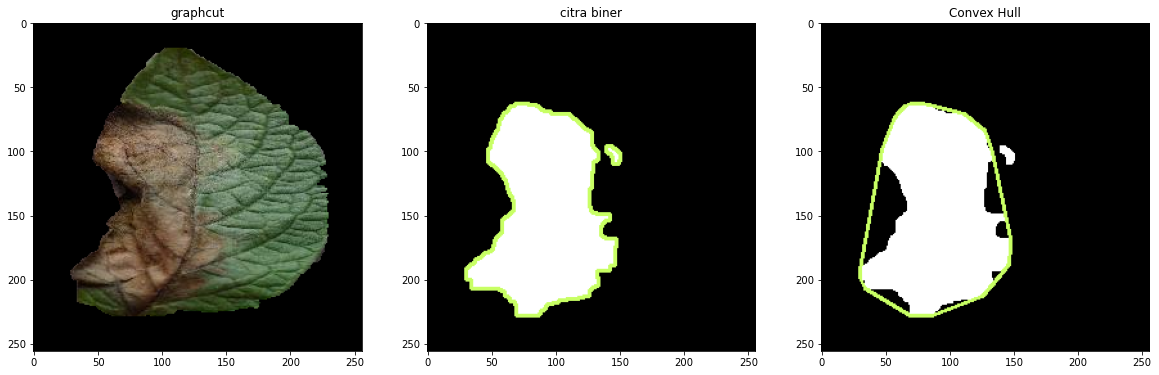

2
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(256, 256)

In [4]:
image = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
b,g,r = cv2.split(image)
glcm(res_gray,135)
def convexhull(img):
    citraBerwarna = cv2.merge((img, img, img))
    kontur, hirarki = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    luas = 0
    posisi = 0
    for i in range(len(kontur)):
        luas = cv2.contourArea(kontur[i])
        if i == 0:
            posisi = 0
            terbesar = luas
        else :
            if luas > terbesar:
                posisi = i
                terbesar = luas
                luas = terbesar
    convex = cv2.convexHull(kontur[posisi])
    cv2.drawContours(citraBerwarna, [convex],-1, (200,255,100), 2)
    return citraBerwarna

def area(img):
    citraBerwarna = cv2.merge((img, img, img))
    kontur, hirarki = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    luas = 0
    l=0
    terbesar =0
    for i in range(len(kontur)):
        if len(kontur)==0:
            l=0
        else:        
            luas = cv2.contourArea(kontur[i])
            if i == 0:
                posisi = 0
                terbesar = luas
            else :
                if luas > terbesar:
                    posisi = i
                    terbesar = luas
                    luas = terbesar
    for i in range(len(kontur)):
        if i != posisi:
            cv2.drawContours(citraBerwarna,kontur,
                             -1, (200,255,100), 2)
    l = terbesar
    return citraBerwarna

def glcm(imag, degree):
    scale_percent = 60 # percent of original size
    width = int(imag.shape[1] * scale_percent / 100)
    height = int(imag.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(imag, dim, interpolation = cv2.INTER_AREA)
    arr = np.array(resized)
    res = np.zeros((arr.max() + 1, arr.max()+1), dtype=int)
    w,h=arr.shape
    if degree == 0:
        for i in range(w-1):
            for j in range (h-1):
                if arr[j, i+1] and arr[j, i] == 0:
                    res[arr[j, i+1], arr[j, i]] += 0
                else:
                    res[arr[j, i+1], arr[j, i]] += 1
    elif degree == 45:
        for i in range(w-1):
            for j in range(h-1):
                res[arr[j-1, i+1], arr[j, i]] += 1
    elif degree == 90:
        for i in range(w-1):
            for j in range(h-1):
                res[arr[j-1, i], arr[j, i]] += 1
    elif degree == 135:
        for i in range(w-1):
            for j in range(h-1):
                res[arr[j-1, i-1], arr[j,i]] += 1
    else:
        print('sudut tidak ada')
    return res

def correlatio(matrix):
    w, h = matrix.shape
    res = 0
    jml =0 
    stdv=0
    for i in range(w):
        for j in range(h):
            jml += matrix[i][j]             
    rata = jml/(w*h)
    for i in range(w):
        for j in range(h):
            stdv += np.power((matrix[i][j] - rata),2)
    standar_deviasi = math.sqrt(stdv/(w*h))
    for i in range(w):
        for j in range(h):
            res += (((i-rata)*(j-rata)*matrix[i][j])/(np.power(standar_deviasi,2)))
    return rata, standar_deviasi

def jumlahkontur(img):
    citraBerwarna = cv2.merge((img, img, img))
    kontur, hirarki = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return len(kontur)

def show_image(img1, text1, img2, text2, img3, text3, size):
    fig = plt.figure(1,figsize=size)
    oris = fig.add_subplot(1,3,1)
    oris.title.set_text(text1)
    plt.imshow(img1, cmap= 'gray')
    
    meds = fig.add_subplot(1,3,2)
    meds.title.set_text(text2)
    plt.imshow(img2, cmap= 'gray')
    
    segmen = fig.add_subplot(1,3,3)
    segmen.title.set_text(text3)
    plt.imshow(img3)
    
    plt.show()

lab = cv2.cvtColor(res2, cv2.COLOR_BGR2GRAY)
ret, tres = cv2.threshold(lab, 0, 255, cv2.THRESH_BINARY)

#L,A,B=cv2.split(lab)
#plt.rcParams['font.size'] = 14

#show_image(res2,'', lab,'grayscale', res2, '', (20,10))
show_image(res,'graphcut', area(thresh), 'citra biner', convexhull(thresh),'Convex Hull', (20,10))
print(jumlahkontur(thresh))
matriks = glcm(res_gray,135)
#rataR = np.sum(r)/(x*y)
#rataB = np.sum(b)/(x*y)
#rataG = np.sum(g)/(x*y)

j = b+g+r
print(j)
j.shape
#print(rataB)
#print((rataR+rataB+rataG)/3)

,Contrast,Energy,Homogenity,Correlation,Mean,St.Deviasi,Skewness,Kurtosis,Area,Perimeter,Solidity,Compactness,Convexity,Jenis Daun
0,3387035,426756518,20802.757611,2329.671698,67.632548,82.734350,0.860106,2.226210,1374.5,199.639609,0.746605,0.433153,0.835652,early blight
1,2981494,422635015,20678.925312,2862.578987,70.780192,86.357111,0.729668,1.980532,1404.0,208.367531,0.740116,0.406160,0.806316,early blight
2,1597889,472281968,21816.576695,721.794651,60.142390,83.427250,1.032554,2.588830,338.0,76.041630,0.946779,0.734182,0.941921,early blight
3,2887726,452713681,21345.551032,1641.718560,48.443695,82.672852,1.393999,3.089705,402.0,91.941125,0.881579,0.597305,0.940169,early blight
4,2559642,450376185,21310.081252,660.438792,46.797689,75.350361,1.502072,3.745117,451.0,99.213203,0.941545,0.575476,0.869681,early blight


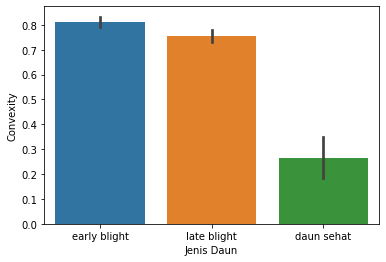

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import DataFrame

import time
import seaborn as sns

# df = pd.read_excel (r'D:\KULIAH\Tugas Kuliah\Semester 8\Skripsi\dataset\dataskripsi.xlsx')
df = pd.read_excel (r'D:\KULIAH\Tugas Kuliah\Semester 8\Skripsi\dataset\datapenelitiansebelumnya.xlsx')

# df = pd.read_excel(r'dearly.xlsx')
df.rename(columns={'Target':'Jenis Daun'}, inplace=True)
df['Jenis Daun']= df['Jenis Daun'].map({0:'early blight',1:'late blight', 2:'daun sehat'})
sns.barplot(x='Jenis Daun', y='Convexity', data =df);
df.head()


In [7]:
# X=df.drop(['Jenis Daun', 'Area', 'Perimeter','Solidity', 'Compactness', 'Convexity'], axis=1)
X=df.drop(['Jenis Daun'], axis=1)

X.head()

,Contrast,Energy,Homogenity,Correlation,Mean,St.Deviasi,Skewness,Kurtosis,Area,Perimeter,Solidity,Compactness,Convexity
0,3387035,426756518,20802.757611,2329.671698,67.632548,82.734350,0.860106,2.226210,1374.5,199.639609,0.746605,0.433153,0.835652
1,2981494,422635015,20678.925312,2862.578987,70.780192,86.357111,0.729668,1.980532,1404.0,208.367531,0.740116,0.406160,0.806316
2,1597889,472281968,21816.576695,721.794651,60.142390,83.427250,1.032554,2.588830,338.0,76.041630,0.946779,0.734182,0.941921
3,2887726,452713681,21345.551032,1641.718560,48.443695,82.672852,1.393999,3.089705,402.0,91.941125,0.881579,0.597305,0.940169
4,2559642,450376185,21310.081252,660.438792,46.797689,75.350361,1.502072,3.745117,451.0,99.213203,0.941545,0.575476,0.869681


In [8]:
y = df['Jenis Daun']
y.head()

0    early blight
1    early blight
2    early blight
3    early blight
4    early blight
Name: Jenis Daun, dtype: object

In [9]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 10) 
print('Size train "X" =',X_train.shape)
print('Size test "X" =',X_test.shape)
print('Size train "y" =',y_train.shape)
print('Size test "y" =',y_test.shape)

Size train "X" = (180, 13)
Size test "X" = (120, 13)
Size train "y" = (180,)
Size test "y" = (120,)


In [10]:
X_train_min = X_train.min()
X_train_min
X_train_max = X_train.max()
X_train_max
X_train_range = (X_train_max - X_train_min)
X_train_scaled = (X_train - X_train_min)/(X_train_range)
X_train_scaled.head()

,Contrast,Energy,Homogenity,Correlation,Mean,St.Deviasi,Skewness,Kurtosis,Area,Perimeter,Solidity,Compactness,Convexity
175,0.138386,0.534008,0.587756,0.072353,0.211424,0.665238,0.714495,0.394974,0.353448,0.256775,0.789595,0.572318,0.864133
174,0.149425,0.663674,0.723998,0.061153,0.285906,0.340887,0.739255,0.538756,0.188462,0.220325,0.816142,0.414488,0.921029
63,0.262736,0.771342,0.792441,0.061336,0.397925,0.324524,0.637848,0.464765,0.025692,0.058457,0.941648,0.802692,0.883008
1,0.420988,0.670478,0.694980,0.335265,0.802350,0.624014,0.166662,0.057394,0.087660,0.133038,0.740116,0.528766,0.806316
253,0.015282,0.938833,0.953134,0.000404,0.255019,0.364734,0.739625,0.527282,0.043861,0.101927,0.837306,0.450735,0.932859


In [11]:
X_test_min = X_test.min()
X_test_max = X_test.max()
X_test_range = (X_test_max - X_test_min)
X_test_scaled = (X_test - X_test_min)/(X_test_range)
X_test_scaled.head()

,Contrast,Energy,Homogenity,Correlation,Mean,St.Deviasi,Skewness,Kurtosis,Area,Perimeter,Solidity,Compactness,Convexity
24,0.369667,0.736860,0.761667,0.069237,0.639262,0.366559,0.381756,0.244664,0.015830,0.050958,0.920750,0.494488,0.940347
65,0.515592,0.758041,0.780321,0.140925,0.871466,0.463259,0.134616,0.070874,0.032277,0.088966,0.631450,0.330776,0.756833
113,0.279031,0.511755,0.580203,0.166075,0.295025,0.137195,0.800906,0.742215,0.256838,0.241942,0.681464,0.355902,0.811856
261,0.004958,0.994065,0.994669,0.000091,0.391245,0.043733,0.652431,0.612739,0.000000,0.000000,0.000000,0.000000,0.000000
188,0.660509,0.517110,0.548767,0.296396,0.579327,0.310897,0.458466,0.330749,0.267778,0.286539,0.709082,0.264546,0.618821


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                   {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [10, 100, 1000]}]
scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(decision_function_shape='ovo'), tuned_parameters, scoring='%s_macro' % score)
    clf.fit(X_train_scaled, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%f (+/-%f) for %r" % (mean, std * 2, params))
    print()
    
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_scaled)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision



D:\sofware\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\sofware\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\sofware\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\sofware\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Pr

Best parameters set found on development set:

{'C': 10, 'kernel': 'linear'}

Grid scores on development set:

0.953219 (+/-0.040401) for {'C': 1, 'kernel': 'linear'}
0.969475 (+/-0.039186) for {'C': 10, 'kernel': 'linear'}
0.967444 (+/-0.063878) for {'C': 100, 'kernel': 'linear'}
0.941969 (+/-0.083209) for {'C': 1000, 'kernel': 'linear'}
0.481360 (+/-0.053772) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.114815 (+/-0.009072) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.930449 (+/-0.116839) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.481360 (+/-0.053772) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.965568 (+/-0.038931) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.930449 (+/-0.116839) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

  daun sehat       0.98      1.00     

In [13]:
# training a linear SVM classifier 
from sklearn.svm import SVC 
from sklearn.svm import LinearSVC 

svm_model_linear = SVC(decision_function_shape='ovo', kernel = 'precomputed', C=10)

gram_train = np.dot(X_train_scaled, X_train_scaled.T)
svm_model_linear.fit(gram_train, y_train)
gram_test = np.dot(X_test_scaled, X_train_scaled.T)
svm_predictions = svm_model_linear.predict(gram_test)
print(classification_report(y_test, svm_predictions)) 


              precision    recall  f1-score   support

  daun sehat       0.98      1.00      0.99        40
early blight       0.97      0.97      0.97        38
 late blight       1.00      0.98      0.99        42

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120



In [14]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

cm = confusion_matrix(y_test, svm_predictions)
# cm = np.array(confusion_matrix(y_test, svm_predictions, labels=[0,1,2]))

cls = classification_report(y_test, svm_predictions)

confusion = pd.DataFrame(cm, index=['early blight', 'late blight', 'healthy'],
                        columns=['predik early', 'prediksi late', 'predik health'])

print('akurasi : ', accuracy_score(y_test, svm_predictions))
print('f1=score : ', f1_score(y_test, svm_predictions, average="macro"))
print('presisi :', precision_score(y_test, svm_predictions, average="macro"))
print('recall :', recall_score(y_test, svm_predictions, average="macro"))  

confusion

akurasi :  0.9833333333333333
f1=score :  0.9830967795809619
presisi : 0.9830979888746256
recall : 0.9832915622389308


,predik early,prediksi late,predik health
early blight,40,0,0
late blight,1,37,0
healthy,0,1,41


# Klasifikasi KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)

model.fit(X_train_scaled, y_train)
predict = model.predict(X_test_scaled)

print(classification_report(y_test, predict)) 

cm = confusion_matrix(y_test, predict)
# cm = np.array(confusion_matrix(y_test, svm_predictions, labels=[0,1,2]))

confusion = pd.DataFrame(cm, index=['early blight', 'late blight', 'healthy'],
                        columns=['predik early', 'prediksi late', 'predik health'])
print(confusion)

              precision    recall  f1-score   support

  daun sehat       0.95      1.00      0.98        40
early blight       0.92      0.92      0.92        38
 late blight       0.97      0.93      0.95        42

    accuracy                           0.95       120
   macro avg       0.95      0.95      0.95       120
weighted avg       0.95      0.95      0.95       120

              predik early  prediksi late  predik health
early blight            40              0              0
late blight              2             35              1
healthy                  0              3             39


In [158]:
from itertools import combinations
from sklearn.svm import SVC 
from scipy.stats import mode

X_train_scaled2 = np.array(X_train_scaled)

def predict_class(X, classifiers, distinct_classes, class_pairs):
    results = []
    for x_row in X:

        class_list = list(distinct_classes)

        # After each prediction, delete the rejected class
        # until there is only one class
        while len(class_list) > 1:
            # We start with the pair of the first and last element in the list
            class_pair = (class_list[0], class_list[-1])
            classifier_index = class_pairs.index(class_pair)
            y_pred = classifiers[classifier_index].predict([x_row])

            if y_pred == 1:
                class_to_delete = class_pair[1]
            else:
                class_to_delete = class_pair[0]

            class_list.remove(class_to_delete)

        results.append(class_list[0])
    return np.array(results)

training_data = []
class_pairs = list(combinations(set(np.array(y_train)), 2))
for class_pair in class_pairs:
    class_mask = np.where((np.array(y_train) == class_pair[0]) | (np.array(y_train) == class_pair[1]))
    y_i = np.where(np.array(y_train)[class_mask] == class_pair[0], 1, -1)
    training_data.append((X_train_scaled2[class_mask], y_i))


classifiers = []
for data in training_data:
    clf = SVC(kernel='linear', C=1)
    clf.fit(data[0], data[1])
    classifiers.append(clf)


In [162]:
X_test_scaled2 = np.array(X_test_scaled)
predik_dag = predict_class(X_test_scaled2, classifiers, set(y_train), class_pairs)

# classifiers[1].predict(X_test_scaled2)
# print(X_test_scaled2[1])
print(classification_report(y_test, predik_dag)) 

cm = confusion_matrix(y_test, predik_dag)
# cm = np.array(confusion_matrix(y_test, svm_predictions, labels=[0,1,2]))

confusion2 = pd.DataFrame(cm, index=['early blight', 'late blight', 'healthy'],
                        columns=['predik early', 'prediksi late', 'predik health'])
print(confusion2)
# print(X_test_scaled2)

              precision    recall  f1-score   support

  daun sehat       0.98      1.00      0.99        40
early blight       0.97      0.97      0.97        38
 late blight       1.00      0.98      0.99        42

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120

              predik early  prediksi late  predik health
early blight            40              0              0
late blight              1             37              0
healthy                  0              1             41
